# Building a FloPy Plugin using the Plugin Template without the API Package

The MODFLOW-6 API supports a BMI interface which allows you to modify the behavior of MODFLOW-6.  FloPy plugins streamline the process of using MODFLOW-6's BMI interface by:

* Providing template generators to help rapidly set up the interface for your plugin
* Integrating FloPy plugins as a part of MODFLOW-6 simulations so that adding a FloPy plugin to your simulation is as easy as adding a MODFLOW-6 package to your simulation 
* Providing an interface that allows FloPy plugins to work together

This notebook demonstrates how to create a FloPy plugin that modifies the behavior of MODFLOW-6 and existing MODFLOW-6 packages.  This notebook describes the process of building a FloPy plugin using the FloPy template generator, which creates the FloPy plugin files you will need to get started quickly. In this specific example we build a FloPy plugin that modifies the WEL package to transfer water from one location to another (injection well in one location and pumping well in another) when heads in a third location drop below a pre-defined level.

To create this plugin, first define the model type that your FloPy plugin supports and pick a three letter abbreviation for your plugin.

In [ ]:
# define the model type
mt = "gwf"

# define the stress plugin three letter abbreviation (wpf for well package modifier)
pn = "wpf"

Next define any user-specified settings for this plugin.  These settings will exist in a "package" file similar to the files used to store MODFLOW-6 package user-specified settings.  The flopy plugin template generator can set up an options, package, and stress period block for this plugin's settings file.  Below we set the stress period block to contain the following:

    wel_pkg_name: The name of the well package that this plugin is modifying
    wel_num: The well number of the well to transfer water from
    dest_wel_num: The well number of the well to transfer water to
    cellid: The cellid where water levels will be monitored
    trigger_flow_depth: If heads in cellid drop below trigger_flow_depth, water is transfered from wel_num to dest_wel_num
    q: Amount of water that is transferred from wel_num to dest_wel_num
    aux: Support for auxilary variables
    boundname: Support for boundnames
    

In [ ]:
# define the stress plugin stress period data
spv = {"wel_pkg_name": {"type": "string"},
       "wel_num": {"type": "integer"},
       "dest_well_num": {"type": "integer"},
       "cellid": {"type": "integer", "shape": "ncelldim"},
       "trigger_flow_head": {"type": "double precision"},
       "q": {"type": "double precision"},
       "aux": {"type": "double precision", "shape": "naux",
               "optional": "True"},
       "boundname": {"type": "string", "optional": "True"}}

Now that all of your plugin interface information is defined, run the FloPy plugin template generator "generate_plugin_template", passing the information you just defined.  This plugin just modifies an existing wel package, so api_package_support is set to False.  For this example we will transfer water based on the heads from the last stress period, so our code will execute at the start of each stress period.  Therefore evaluation_code_at is set to "stress_period_start".

In [ ]:
import flopy

flopy.mf6.utils.flopy_plugins.plugin_template.generate_plugin_template(
    mt,
    pn,
    stress_period_vars=spv,
    api_package_support=False,
    evaluation_code_at="stress_period_start")

## Working with flopy_wpf_plugin.py

The plugin template generator creates and modifies several files.  The python file that you will edit in order to add functionality to your plugin is in the "mf6/utils/flopy_plugins/plugins" folder and in this case is named "flopy_wpf_plugin.py" (the "wpf" part of the name is based on the three letter abbreviation choosen above).  This file contains a class with several methods.  

### init_plugin()
This method is called immediately before to the start of a model run.  The init_plugin method has been filled out for you to retreive all of your plugin settings from the plugin input file here.  

### stress_period_start(self, sp, sln_group)
This method is called immediately after the MODFLOW-6 prepare_solve method is called for a new stress period.  The stress_period_start method has also been filled out for you, and the appropriate stress period data is loaded here.

This method receives the current stress period (sp) and the modflowapi interface to the solution group currently being solved for (sln_group).  For simulations with more than one solution group, the flopy plug-in is associated with a specific solution group based on what model it is a part of and the FloPy plug-in callback occurrs only when that solution group is being solved.  To override this behavior and receiving a callback when all solution groups are beings solved, set the run_for_all_solution_groups attribute to True.

### time_step_start(self, sp, ts, sln_group)
This method is called immediately after the MODFLOW-6 prepare_solve method is called.

This method receives the current stress period (sp), the current time step (ts), and the modflowapi interface to the solution group currently being solved for (sln_group).  For simulations with more than one solution group, the FloPy plug-in is associated with a specific solution group based on what model it is a part of and the FloPy plug-in callback occurrs only when that solution group is being solved.  To override this behavior and receiving a callback when all solution groups are beings solved, set the run_for_all_solution_groups attribute to True.

### iteration_start(self, sp, ts, iter_num, sln_group)
This method is called for each MODFLOW-6 outer iteration, immediately before the MODFLOW-6 solve method is called.  The iteration_start method has been partially filled out with code that loops through each of the user-defined stress period records in the current stress period, getting the values in the record for you.  In this loop you may want to add code that modifies the MODFLOW-6 behavior, for example by changing the values of an existing MODFLOW-6 package's nodelist, hcof, rhs, and/or bound variables.

This method receives the current stress period (sp), the current time step (ts), current iteration number (iter_num) and the modflowapi interface to the solution group currently being solved for (sln_group).  For simulations with more than one solution group, the FloPy plug-in is associated with a specific solution group based on what model it is a part of and the flopy plug-in callback occurrs only when that solution group is being solved.  To override this behavior and receiving a callback when all solution groups are beings solved, set the run_for_all_solution_groups attribute to True.

### other methods you can override
Additionally you can override the following methods.

* receive_vars(self, simulation, model, package, user_kwargs) - When this method is called your FloPy plug-in receives FloPy objects related to your plugin (simulation, model, package) and also any kwargs passed by the user in the sim.run_simulation() call (user_kwargs).  If you override this method, the receive_vars base class method MUST be called first in order to FloPy plug-ins to function correctly.

* receive_bmi(self, mf6_sim) - This method is called immediately after the MODFLOW-6 API is initialized and is passed a modflowapi Simulation object providing access to the MODFLOW-6 API (mf6_sim).  If you override this method, the recieve_bmi base class method MUST be called first in order to FloPy plug-ins to function correctly.

* iteration_end(self, sp, ts, iter_num, sln_group) - This method is called immediately after the end of the current MODFLOW-6 outer iteration.  This method's parameters are the current stress period (sp), the current time step (ts), current iteration number (iter_num) and the modflowapi interface to the solution group currently being solved for (sln_group).  If you override this method, the iteration_end base class method MUST be called first in order to FloPy plug-ins to function correctly.

* time_step_end(self, sp, ts, converged, sln_group) - This method is called immediately after the end of the current MODFLOW-6 time step.  This method's parameters are the current stress period (sp), the current time step (ts), whether the time step converged on a solution, and the modflowapi interface to the solution group currently being solved for (sln_group).  If you override this method, the time_step_end base class method MUST be called first in order to FloPy plug-ins to function correctly.

* stress_period_end(self, sp, sln_group) - This method is called immediately after the end of the last MODFLOW-6 time step in a stress period.  This method parameters are the current stress period (sp) and the modflowapi interface to the solution group currently being solved for (sln_group).  If you override this method, the stress_period_end base class method MUST be called first in order to FloPy plug-ins to function correctly.

* sim_complete() - This method is called immediately after the MODFLOW-6 simulation is complete.

## Other files used by FloPy plugins

The FloPy plugin template also creates a "gwf-fp_wpf.dfn" file in "mf6/data/dfn" and then runs createpackages.py to create the package interface file, "mfgwffp_wpf.py" in "mf6/modflow".  You can manually edit the dfn file to add more options, stress period vars, or other data blocks to your plugin.  After modifying the dfn you will need to run createpackages.py to update your mfgwffp_wpf.py file and add the appropriate code to flopy_wpf_package.py to retreive and work with the new data.

## Other modifications made for FloPy plugins

Your package interface file, "mfgwffp_wpf.py", and FloPy plugin file, "flopy_wpf_plugin.py" were both added to "\__init\__.py" in their respective folders.  These files must be in \__init\__.py for FloPy to autodetect and use them at run time.

## Example modification to flopy_wpf_plugin.py

Find the generated flopy_wpf_plugin.py file.  This file will be in your python folder under "Lib\site-packages\flopy\mf6\utils\flopy_plugins".  Add the following lines to flopy_wpf_plugin.py after the "# ADD YOUR CODE HERE" comment. Make sure the indent of the beginning of the code added lines up with the comment.
            

                        self.mf6_default_package = wel_pkg_name
                        # get mf6 variables
                        spd = self.mf6_default_package.stress_period_data
                        cur_nodelist = spd["nodelist"]
                        hcof_list = self.mf6_default_package.hcof
                        rhs_list = self.mf6_default_package.rhs
                        bound = self.mf6_default_package.get_advanced_var("bound")

                        # get node from wel num
                        if len(cur_nodelist) > wel_num and \
                                len(cur_nodelist) > dest_well_num:
                            # get node
                            trigger_node = self.get_node(cellid)
                            trigger_node_reduced = self.mf6_model.usertonode[trigger_node]

                            # check water level elevation at injection well
                            x_new = self.mf6_model.X.flatten()
                            head = x_new[trigger_node_reduced]
                            if head < trigger_flow_head:
                                # water levels dropped below critical level, pump from
                                # extraction well transferring all of its water to the
                                # injection well
                                rhs_list[dest_well_num] = -q
                                bound[dest_well_num, 0] = q
                                rhs_list[wel_num] = q
                                bound[wel_num, 0] = -q
                            else:
                                # water levels are above critical level, turn off water
                                # transfer
                                rhs_list[dest_well_num] = 0.0
                                bound[dest_well_num, 0] = 0.0
                                rhs_list[wel_num] = 0.0
                                bound[wel_num, 0] = 0.0

                        # update wel package variables
                        self.mf6_default_package.rhs = rhs_list
                        self.mf6_default_package.hcof = \
                            hcof_list
                        self.mf6_default_package.\
                            set_advanced_var("bound", bound)

### Before you proceed restart the python kernel so that it is up to date with your changes
    
Before you proceed restart the python kernel so that it is up to date with your changes above.
Now we can create and run a model to test the new FloPy plugin you created. First, a simple simulation with a WEL and GHB stress package is created in FloPy.

In [1]:
import numpy as np
from flopy.mf6.modflow.mfgwf import ModflowGwf
from flopy.mf6.modflow.mfgwfdis import ModflowGwfdis
from flopy.mf6.modflow.mfgwfghb import ModflowGwfghb
from flopy.mf6.modflow.mfgwfic import ModflowGwfic
from flopy.mf6.modflow.mfgwfnpf import ModflowGwfnpf
from flopy.mf6.modflow.mfgwfoc import ModflowGwfoc
from flopy.mf6.modflow.mfgwfwel import ModflowGwfwel
from flopy.mf6.modflow.mfims import ModflowIms
from flopy.mf6.modflow.mfgwfsto import ModflowGwfsto
from flopy.mf6.modflow.mfsimulation import MFSimulation
from flopy.mf6.modflow.mftdis import ModflowTdis

sim = MFSimulation(
    sim_name="flopy_wpf_test",
    version="mf6",
    exe_name="mf6.exe",
    sim_ws="flopy_wpf_test",
    continue_=True,
    memory_print_option="summary",
)

tdis_rc = [(100.0, 1, 1.0), (100.0, 1, 1.0)]
tdis_package = ModflowTdis(
    sim, time_units="DAYS", nper=2, perioddata=tdis_rc,
    start_date_time="1/1/2010",
)

ims_package = ModflowIms(
    sim,
    filename="flopy_wpf_test.ims",
    print_option="ALL",
    complexity="SIMPLE",
    outer_dvclose=0.00001,
    outer_maximum=50,
    under_relaxation="NONE",
    inner_maximum=30,
    inner_dvclose=0.00001,
    linear_acceleration="CG",
    preconditioner_levels=7,
    preconditioner_drop_tolerance=0.01,
    number_orthogonalizations=2,
)

model = ModflowGwf(
    sim, modelname="flopy_wpf_test", model_nam_file="flopy_wpf_test.nam"
)

nlay = 2
nrow = 10
ncol = 10
dis_package = ModflowGwfdis(
    model,
    length_units="FEET",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=500.0,
    delc=500.0,
    top=100.0,
    botm=[50.0, 0.0],
    pname="mydispkg",
)

ic_package = ModflowGwfic(
    model, strt=80.0
)

oc_package = ModflowGwfoc(
    model,
    head_filerecord=["flopy_wpf_test.hds"],
    budget_filerecord=["flopy_wpf_test.cbc"],
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

npf_package = ModflowGwfnpf(
    model,
    save_flows=True,
    alternative_cell_averaging="logarithmic",
    icelltype=1,
    k=5.0,
    k33=0.001,
)

sto_package = ModflowGwfsto(
    model, save_flows=True, iconvert=1, ss=0.000001, sy=0.15
)

ghb_package = ModflowGwfghb(
    model,
    print_input=True,
    print_flows=True,
    maxbound=10,
    stress_period_data=[((0, 0, 0), 100.0, 60.0), ((0, 0, 1), 100.0, 60.0),
                        ((0, 0, 2), 100.0, 60.0),
                        ((0, 0, 3), 100.0, 60.0), ((0, 0, 4), 100.0, 60.0),
                        ((0, 0, 5), 100.0, 60.0),
                        ((0, 0, 6), 100.0, 60.0), ((0, 0, 7), 100.0, 60.0),
                        ((0, 0, 8), 100.0, 60.0),
                        ((0, 0, 9), 100.0, 60.0), ],
)

wel_package = ModflowGwfwel(
    model,
    pname="wel_0",
    print_input=True,
    print_flows=True,
    maxbound=10,
    stress_period_data={0: [((1, 8, 0), 0.0), ((1, 1, 8), 0.0),
                            ((1, 9, 0), -5000.0)],
                        1: [((1, 8, 0), 0.0), ((1, 1, 8), 0.0),
                            ((1, 9, 1), -5000.0)]},
)

Next, the FloPy plugin we just created is added to the simulation.  In this case we are transferring 5000.0 ft/day of water from the second well to the first well when cell at layer/row/column (2, 6, 1) falls below 70.0 ft head.

In [2]:
from flopy.mf6.modflow.mfgwffp_wpf import ModflowGwffp_Wpf

# Create flopy "wpf" plugin stress period data
wpf_period = {0: [("wel_0", 1, 0, (1, 5, 0), 70.0, 5000.0)],
              1: [("wel_0", 1, 0, (1, 5, 0), 70.0, 5000.0)]}
# Create flopy "wpf" plugin
wpf_plugin = ModflowGwffp_Wpf(
    model,
    stress_period_data=wpf_period,
)

Finally, save and run the simulation.

In [3]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flopy_wpf_test...
    writing model name file...
    writing package mydispkg...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package ghb_0...
    writing package wel_0...
    writing package fp_wpf...
INFORMATION: maxbound in ('gwf6', 'fp_wpf', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following dll to run the model: C:\Wrdapp\bin\libmf6.dll
NORMAL TERMINATION OF SIMULATION


True

After the simulation completes check the model listing file and note that the water transfer (in the WEL package) only occurs in the second stress period, after the heads dip below 70.0 ft in cell (2, 6, 1) at the end of the first stress period.  Results can be found in the "flopy_wpf_test" folder created next to this notebook.

This can also be observed in the head plots.  In stress period one a well pumps from the lower-left corner of the model, causing some drawdown there. 

<Axes: title={'center': 'data Layer 2'}>

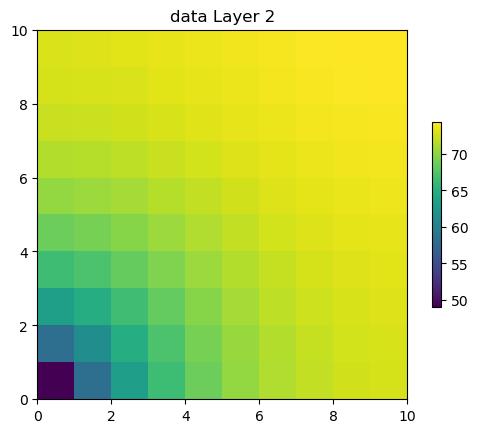

In [4]:
heads = model.output.head()
heads.plot(kstpkper=(0, 0), mflay=1, colorbar=True)

By the end of stress period 1 the heads at cell (2, 6, 1) fall below the 70.0 ft threshold, leading to pumping from the well near the upper right corner of the model and injection of that water into another well near the lower left corner of the model.  This causes drawdown in the upper right corner and some recovery of heads in the lower left corner.

<Axes: title={'center': 'data Layer 2'}>

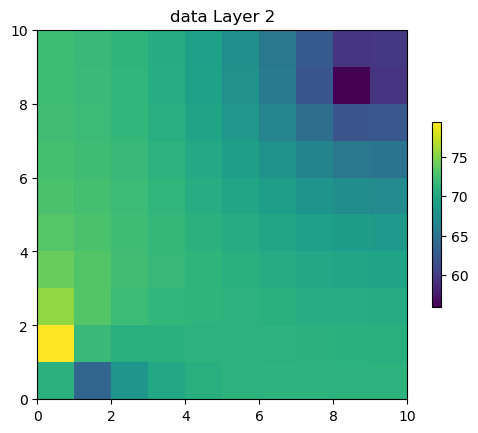

In [5]:
heads.plot(kstpkper=(0, 1), mflay=1, colorbar=True)